In [1]:
#Mini-Project Take 2
By Marissa Beaty

This model was adapted from the research posted on OpenCV available here: https://learnopencv.com/paired-image-to-image-translation-pix2pix/. 

In [2]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from glob import glob
import torch
from torch import nn, optim
from torchvision import transforms

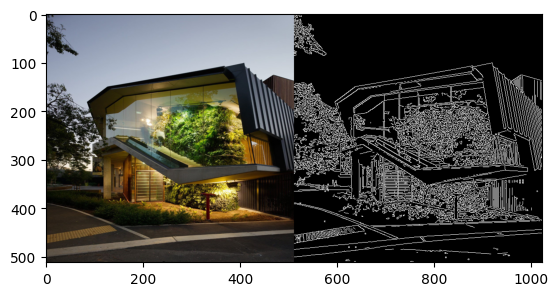

In [2]:
path = '/Training_small/'
image = plt.imread('Training_small/0002.png')
plt.imshow(image)

In [3]:
#checking the shape of an image in the dataset

print("Shape of the Image: ", cv2.imread('Training_small/0001.png').shape)

Shape of the Image:  (512, 1024, 3)


In [2]:
#dividing the image by width

image = cv2.imread('Training_small/0001.png')
w = image.shape[1]//2
image_real = image[:, :w, :]
image_cond = image[:, w:, :]
fig, axes = plt.subplots(1,2, figsize=(18,6))
axes[0].imshow(image_real, label='Real')
axes[1].imshow(image_cond, label='Condition')
plt.show()

In [33]:
def __getitem__(filename):
    #filename = self.filenames[idx]

    image = cv2.imread(filename)
    image_width = image.shape[1]
    image_width = image_width // 2
    real = image[:, :image_width, :]
    condition = image[:, image_width:, :]

    print(real.shape())

In [39]:
image = cv2.imread("Training_small/0001.png")
image_width = image.shape[1]
image_width = image_width // 2
real = image[:, :image_width, :]
print(real.shape())

SyntaxError: invalid syntax. Perhaps you forgot a comma? (813259282.py, line 5)

In [25]:
#creating dataloader

class data(Dataset):
   def __init__(self, path='Training_small/'):
       self.filenames = glob(path+'*.png')

   def __len__(self):
       return len(self.filenames)

   def __getitem__(self, idx):
       filename = self.filenames[idx]

       image = cv2.imread(filename)
       image_width = image.shape[1]
       image_width = image_width // 2
       real = image[:, :image_width, :]
       condition = image[:, image_width:, :]

       real = transforms.Compose([transforms.RandomResizedCrop(512),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor()])
       condition = transforms.Compose([transforms.RandomResizedCrop(512),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor()])

       return real, condition

In [7]:
#Loading the data by using Pytorch’s DataLoader function to create batches before feeding them into the neural nets. 

train_dataset = data()
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = data(path='Training_small/')
val_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


In [8]:
#creating components to build the generator and discriminator
def cnn_block(in_channels,out_channels,kernel_size,stride=1,padding=0, first_layer = False):

   if first_layer:
       return nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding)
   else:
       return nn.Sequential(
           nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
           nn.BatchNorm2d(out_channels,momentum=0.1,eps=1e-5),
           )

def tcnn_block(in_channels,out_channels,kernel_size,stride=1,padding=0,output_padding=0, first_layer = False):
   if first_layer:
       return nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding,output_padding=output_padding)

   else:
       return nn.Sequential(
           nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding,output_padding=output_padding),
           nn.BatchNorm2d(out_channels,momentum=0.1,eps=1e-5),
           )

In [11]:
#defining the generator

class Generator(nn.Module):
 def __init__(self,instance_norm=False):#input : 256x256
   super(Generator,self).__init__()
   self.e1 = cnn_block(c_dim,gf_dim,4,2,1, first_layer = True)
   self.e2 = cnn_block(gf_dim,gf_dim*2,4,2,1,)
   self.e3 = cnn_block(gf_dim*2,gf_dim*4,4,2,1,)
   self.e4 = cnn_block(gf_dim*4,gf_dim*8,4,2,1,)
   self.e5 = cnn_block(gf_dim*8,gf_dim*8,4,2,1,)
   self.e6 = cnn_block(gf_dim*8,gf_dim*8,4,2,1,)
   self.e7 = cnn_block(gf_dim*8,gf_dim*8,4,2,1,)
   self.e8 = cnn_block(gf_dim*8,gf_dim*8,4,2,1, first_layer=True)

   self.d1 = tcnn_block(gf_dim*8,gf_dim*8,4,2,1)
   self.d2 = tcnn_block(gf_dim*8*2,gf_dim*8,4,2,1)
   self.d3 = tcnn_block(gf_dim*8*2,gf_dim*8,4,2,1)
   self.d4 = tcnn_block(gf_dim*8*2,gf_dim*8,4,2,1)
   self.d5 = tcnn_block(gf_dim*8*2,gf_dim*4,4,2,1)
   self.d6 = tcnn_block(gf_dim*4*2,gf_dim*2,4,2,1)
   self.d7 = tcnn_block(gf_dim*2*2,gf_dim*1,4,2,1)
   self.d8 = tcnn_block(gf_dim*1*2,c_dim,4,2,1, first_layer = True)#256x256
   self.tanh = nn.Tanh()

 def forward(self,x):
   e1 = self.e1(x)
   e2 = self.e2(nn.LeakyReLU(e1,0.2))
   e3 = self.e3(nn.LeakyReLU(e2,0.2))
   e4 = self.e4(nn.LeakyReLU(e3,0.2))
   e5 = self.e5(nn.LeakyReLU(e4,0.2))
   e6 = self.e6(nn.LeakyReLU(e5,0.2))
   e7 = self.e7(nn.LeakyReLU(e6,0.2))
   e8 = self.e8(nn.LeakyReLU(e7,0.2))
   d1 = torch.cat([nn.LeakyReLU(self.d1(nn.LeakyReLU(e8)),0.5,training=True),e7],1)
   d2 = torch.cat([F.dropout(self.d2(nn.relu(d1)),0.5,training=True),e6],1)
   d3 = torch.cat([torch.nn.functional.dropout.dropout(self.d3(nn.relu(d2)),0.5,training=True),e5],1)
   d4 = torch.cat([self.d4(nn.relu(d3)),e4],1)
   d5 = torch.cat([self.d5(nn.relu(d4)),e3],1)
   d6 = torch.cat([self.d6(nn.relu(d5)),e2],1)
   d7 = torch.cat([self.d7(nn.relu(d6)),e1],1)
   d8 = self.d8(nn.relu(d7))

   return self.tanh(d8)

In [12]:
#defining the discriminator
class Discriminator(nn.Module):
 def __init__(self,instance_norm=False):#input : 512x512
   super(Discriminator,self).__init__()
   self.conv1 = cnn_block(c_dim*2,df_dim,4,2,1, first_layer=True) # 128x128
   self.conv2 = cnn_block(df_dim,df_dim*2,4,2,1)# 64x64
   self.conv3 = cnn_block(df_dim*2,df_dim*4,4,2,1)# 32 x 32
   self.conv4 = cnn_block(df_dim*4,df_dim*8,4,1,1)# 31 x 31
   self.conv5 = cnn_block(df_dim*8,1,4,1,1, first_layer=True)# 30 x 30

   self.sigmoid = nn.Sigmoid()
 def forward(self, x, y):
   O = torch.cat([x,y],dim=1)
   O = nn.LeakyReLU(self.conv1(O),0.2)
   O = nn.LeakyReLU(self.conv2(O),0.2)
   O = nn.LeakyReLU(self.conv3(O),0.2)
   O = nn.LeakyReLU(self.conv4(O),0.2)
   O = self.conv5(O)

   return self.sigmoid(O)

In [13]:
#defining parameters
batch_size = 4
workers = 2

epochs = 30

gf_dim = 64
df_dim = 64

L1_lambda = 100.0

in_w = in_h = 256
c_dim = 3

device = torch.device("cpu")

In [14]:
#initializing the models
G = Generator().to(device)
D = Discriminator().to(device)

In [17]:
#defining the optimizer and loss function
G_optimizer = optim.Adam(G.parameters(), lr=2e-4,betas=(0.5,0.999))
D_optimizer = optim.Adam(D.parameters(), lr=2e-4,betas=(0.5,0.999))

bce_criterion = nn.BCELoss()
L1_criterion = nn.L1Loss()

In [26]:
#training

for ep in range(epochs):
 for i, data in enumerate(train_loader):

   y, x = data
   x = x.to(device)
   y = y.to(device)

   b_size = x.shape[0]

   real_class = torch.ones(b_size,1,30,30).to(device)
   fake_class = torch.zeros(b_size,1,30,30).to(device)

   #Train D
   D.zero_grad()

   real_patch = D(y,x)
   real_gan_loss=bce_criterion(real_patch,real_class)

   fake=G(x)

   fake_patch = D(fake.detach(),x)
   fake_gan_loss=bce_criterion(fake_patch,fake_class)

   D_loss = real_gan_loss + fake_gan_loss
   D_loss.backward()
   D_optimizer.step()


   #Train G
   G.zero_grad()
   fake_patch = D(fake,x)
   fake_gan_loss=bce_criterion(fake_patch,real_class)

   L1_loss = L1_criterion(fake,y)
   G_loss = fake_gan_loss + L1_lambda*L1_loss
   G_loss.backward()

   G_optimizer.step()

   #Neptune logging
   run["Gen Loss"].log(G_loss.item())
   run["Dis Loss"].log(D_loss.item())
   run['L1 Loss'].log(L1_loss.item())
   run['Gen GAN Loss'].log(fake_gan_loss.item())
   # Log PyTorch model weights
   torch.save(G.state_dict(), 'PIX2PIX.ckpt')
   run['model_checkpoints'].upload('PIX2PIX.ckpt')

   if (i+1)%5 == 0 :
     print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f},D(real): {:.2f}, D(fake):{:.2f},g_loss_gan:{:.4f},g_loss_L1:{:.4f}'
           .format(ep, epochs, i+1, len(train_loader), D_loss.item(), G_loss.item(),real_patch.mean(), fake_patch.mean(),fake_gan_loss.item(),L1_loss.item()))
     G_losses.append(G_loss.item())
     D_losses.append(D_loss.item())
     G_GAN_losses.append(fake_gan_loss.item())
     G_L1_losses.append(L1_loss.item())

     with torch.no_grad():
       G.eval()
       fake = G(fixed_x).detach().cpu()
       G.train()
     figs=plt.figure(figsize=(10,10))
     plt.subplot(1,3,1)
     plt.axis("off")
     plt.title("conditional image (x)")
     plt.imshow(np.transpose(vutils.make_grid(fixed_x, nrow=1,padding=5, normalize=True).cpu(),(1,2,0)))

     plt.subplot(1,3,2)
     plt.axis("off")
     plt.title("fake image")
     plt.imshow(np.transpose(vutils.make_grid(fake, nrow=1,padding=5, normalize=True).cpu(),(1,2,0)))

     plt.subplot(1,3,3)
     plt.axis("off")
     plt.title("ground truth (y)")
     plt.imshow(np.transpose(vutils.make_grid(fixed_y, nrow=1,padding=5, normalize=True).cpu(),(1,2,0)))

     plt.savefig(os.path.join('./','pix2pix'+"-"+str(ep) +".png"))

     run['Results'].log(File(f'pix2pix-{str(ep)}.png'))
     plt.close()
     img_list.append(figs)

TypeError: ToTensor.__init__() takes 1 positional argument but 2 were given

This model gave the error (ToTensor.__init__() takes 1 positional argument but 2 were given). This is in reference to the DataLoader in cell 7 where ToTensor is built into the DataLoader function. Like the first notebook test, this is in reference to the shape of the image when split from one image to two. To go around this, I attempted to bypass the DataLoader and did research into how to manually load the data, or code my own DataLoader, but this proved to be too cumbersome and time consuming to do for a project of this scale. The ideal solution would be to fix the issue of transforming the input and output images (from one image to two and then to tensors). In an attempt to fix this, I also looked into pulling the images separately from different folders, by writing a for loop to match up the names of each image, but there are many other places in the rest of the code and the model which would need to be adjusted to fit this new scheme. Implementing this idea would require a major restructuring of the model. With my current timeframe and knowledge, this idea was no further pursued, and I began looking for a different model that might be structured differently to solve the ongoing DataLoader issue.  